# MultiVisit Analysis of two transits of WASP-189b

We have analysed two visits of HD106315 individually -- now we will use `pycheops.MultiVisit` to analyse both of the visits simultaneously.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from dace.cheops import Cheops
import pycheops
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt
import lmfit as lmf
import re
from pycheops.utils import phaser

Let's load the saved datasets using `MultiVisit` class.

In [2]:
M = pycheops.MultiVisit('WASP-189', ident='none')


 N  file_key                   Aperture last_ GP  Glint pipe_ver
 ---------------------------------------------------------------------------
  1 CH_PR100036_TG000701_V0200 DEFAULT  emcee Yes Yes   13.1.0
  2 CH_PR100036_TG000701_V0200 DEFAULT  emcee Yes Yes   13.1.0
  3 CH_PR100036_TG000702_V0200 DEFAULT  emcee Yes Yes   13.1.0
  4 CH_PR100036_TG000702_V0200 DEFAULT  emcee Yes Yes   13.1.0


In [3]:
rprs = np.random.normal(0.060907361661750425, 0.003144594526637345, 10000)
dep, dep_err = np.mean((rprs**2)*1e6), np.std((rprs**2)*1e6)

"""
star = pycheops.StarProperties(dd.target)
print(star)
"""
teff = np.random.normal(8000, 80, 10000)
logg = np.random.normal(3.9, 0.2, 10000)
mh = np.random.normal(0.29, 0.13, 10000)
h1, h2 = np.zeros(10000), np.zeros(10000)
cdc = pycheops.ld.stagger_power2_interpolator('CHEOPS')
for i in range(len(teff)):
    c1, c2, h1[i], h2[i] = cdc(teff[i], logg[i], mh[i])
# However, since Teff is out of the range of stagger, the above code will produce Nan in h1 and h2
# So, we are using values of h1 and h2 from tutorial.

In [4]:
# I have tried this with nroll=3, but it is better with nroll=1 (Delta  BIC = ~200)
TJD_0 = M.tzero(2456706.4558, 2.7240338) # First argument is T_0 in previous epoch
result = M.fit_transit(unroll=True, nroll=1,
                       extra_priors={
                           'T_0':ufloat(TJD_0,0.1),
                            'h_1':ufloat(0.787, 0.100),
                            'logrhoprior':ufloat(-0.89, 0.33)},
                       burn=512, steps=256, nwalkers=256)

Running burn-in ..


100%|██████████| 512/512 [09:08<00:00,  1.07s/it]

Running sampler ..



100%|██████████| 256/256 [04:21<00:00,  1.02s/it]


In [5]:
print(M.fit_report(min_correl=0.8))

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 220968
    # data points      = 3328
    # variables        = 20
    chi-square         = 4858.79749
    reduced chi-square = 1.46880214
    Akaike info crit   = -51529.1372
    Bayesian info crit = -51406.9346
    RMS residual       = 101.4 ppm
[[Variables]]
    D:               0.00505417 +/- 1.2729e-05 (0.25%) (init = 0.005013542)
    W:               0.06626037 +/- 5.5136e-05 (0.08%) (init = 0.06624882)
    b:               0.46475717 +/- 0.01037338 (2.23%) (init = 0.4222705)
    P:               2.724034 (fixed)
    T_0:             2019.15902 +/- 3.3000e-05 (0.00%) (init = 2019.161)
    f_c:             0 (fixed)
    f_s:             0 (fixed)
    h_1:             0.79528002 +/- 0.00214125 (0.27%) (init = 0.793079)
    h_2:             0.529 (fixed)
    k:               0.07109266 == 'sqrt(D)'
    aR:              4.63582617 == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:            0.99496194 == 'sqrt(1 - (b/aR)*

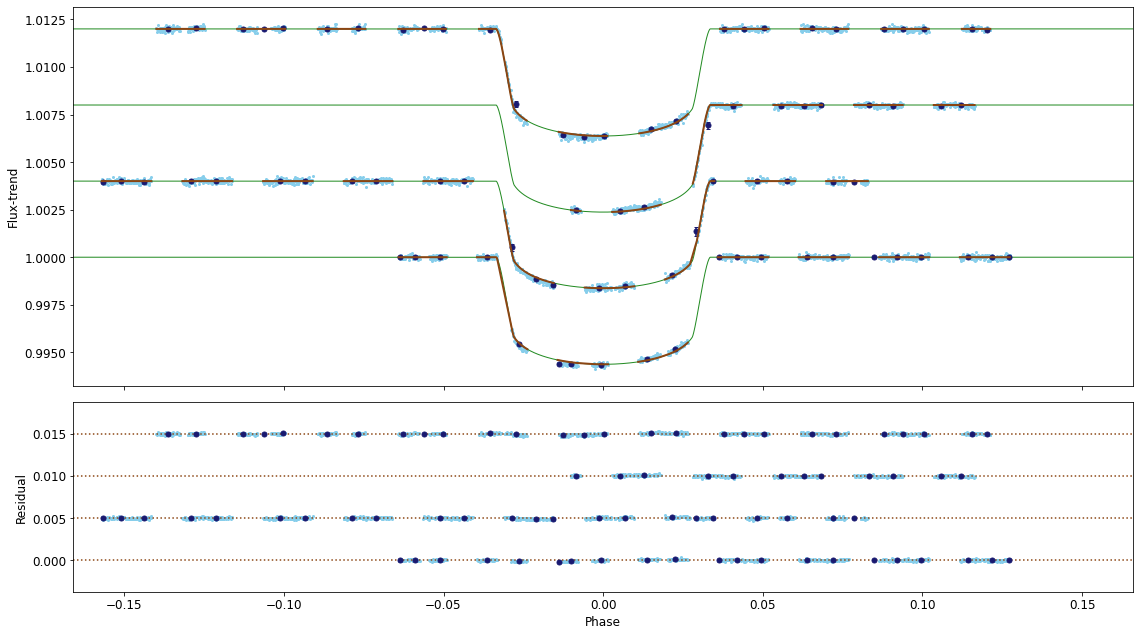

In [6]:
M.plot_fit(binwidth=0.01, data_offset=0.004, res_offset=0.005, detrend=True, figsize=(16,9));

## Trend of Roll-Anlge with time

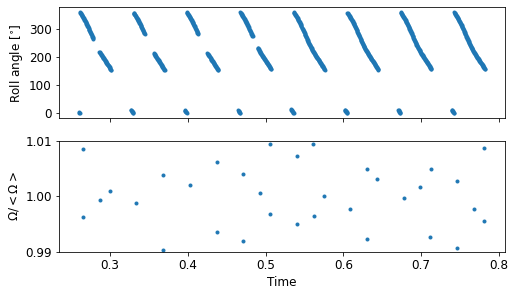

In [7]:
fig,ax = plt.subplots(figsize=(8,4.5),nrows=2,sharex=True)
t = M.datasets[0].lc['time']
t0 = np.floor(t[0])
roll_angle = M.datasets[0].lc['roll_angle']
ax[0].plot(t-t0,roll_angle,'.')
ax[0].set_ylabel('Roll angle [$^{\circ}$]')
drdt = np.gradient(roll_angle)
Omega = np.nanmedian(drdt)
ax[1].plot(t-t0,drdt/Omega,'.')
ax[1].set_ylim(0.99,1.01)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('$\Omega/<\Omega>$');

Wow! The variations can be indeed high! We can remove this correlations as follows:

 - We can either ignore it (only if trends are not large)
 - We can increase nroll (upto which harmonics of roll angle we want to include in decorrelation)
 - Or we can remove the prior decorrelation first and then fit for it (using `unwrap=True`).

In [8]:
result = M.fit_transit(unroll=True, nroll=1, unwrap=True,
                       extra_priors={
                           'T_0':ufloat(TJD_0,0.1),
                           'h_1':ufloat(0.787, 0.100),
                           'logrhoprior':ufloat(-0.89, 0.33)},
                           burn=512, steps=256, nwalkers=256)

Running burn-in ..


100%|██████████| 512/512 [08:34<00:00,  1.00s/it]

Running sampler ..



100%|██████████| 256/256 [04:18<00:00,  1.01s/it]


In [9]:
print(M.fit_report(min_correl=0.8))

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 219837
    # data points      = 3328
    # variables        = 20
    chi-square         = 6614.83910
    reduced chi-square = 1.99964906
    Akaike info crit   = -51722.2523
    Bayesian info crit = -51600.0497
    RMS residual       = 110.8 ppm
[[Variables]]
    D:               0.00502077 +/- 1.3388e-05 (0.27%) (init = 0.005013542)
    W:               0.06619157 +/- 5.4123e-05 (0.08%) (init = 0.06624882)
    b:               0.43638546 +/- 0.01208119 (2.77%) (init = 0.4222705)
    P:               2.724034 (fixed)
    T_0:             2019.15903 +/- 3.2424e-05 (0.00%) (init = 2019.161)
    f_c:             0 (fixed)
    f_s:             0 (fixed)
    h_1:             0.79291660 +/- 0.00203664 (0.26%) (init = 0.793079)
    h_2:             0.529 (fixed)
    k:               0.07085738 == 'sqrt(D)'
    aR:              4.70267804 == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:            0.99568523 == 'sqrt(1 - (b/aR)*

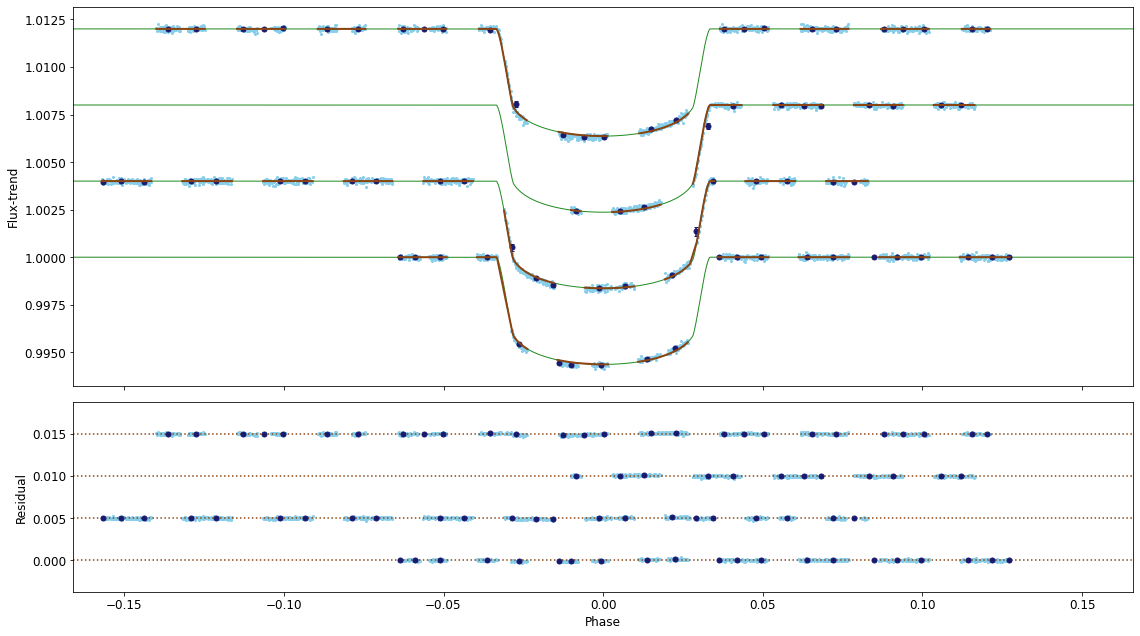

In [10]:
M.plot_fit(binwidth=0.01, data_offset=0.004, res_offset=0.005, detrend=True, figsize=(16,9));

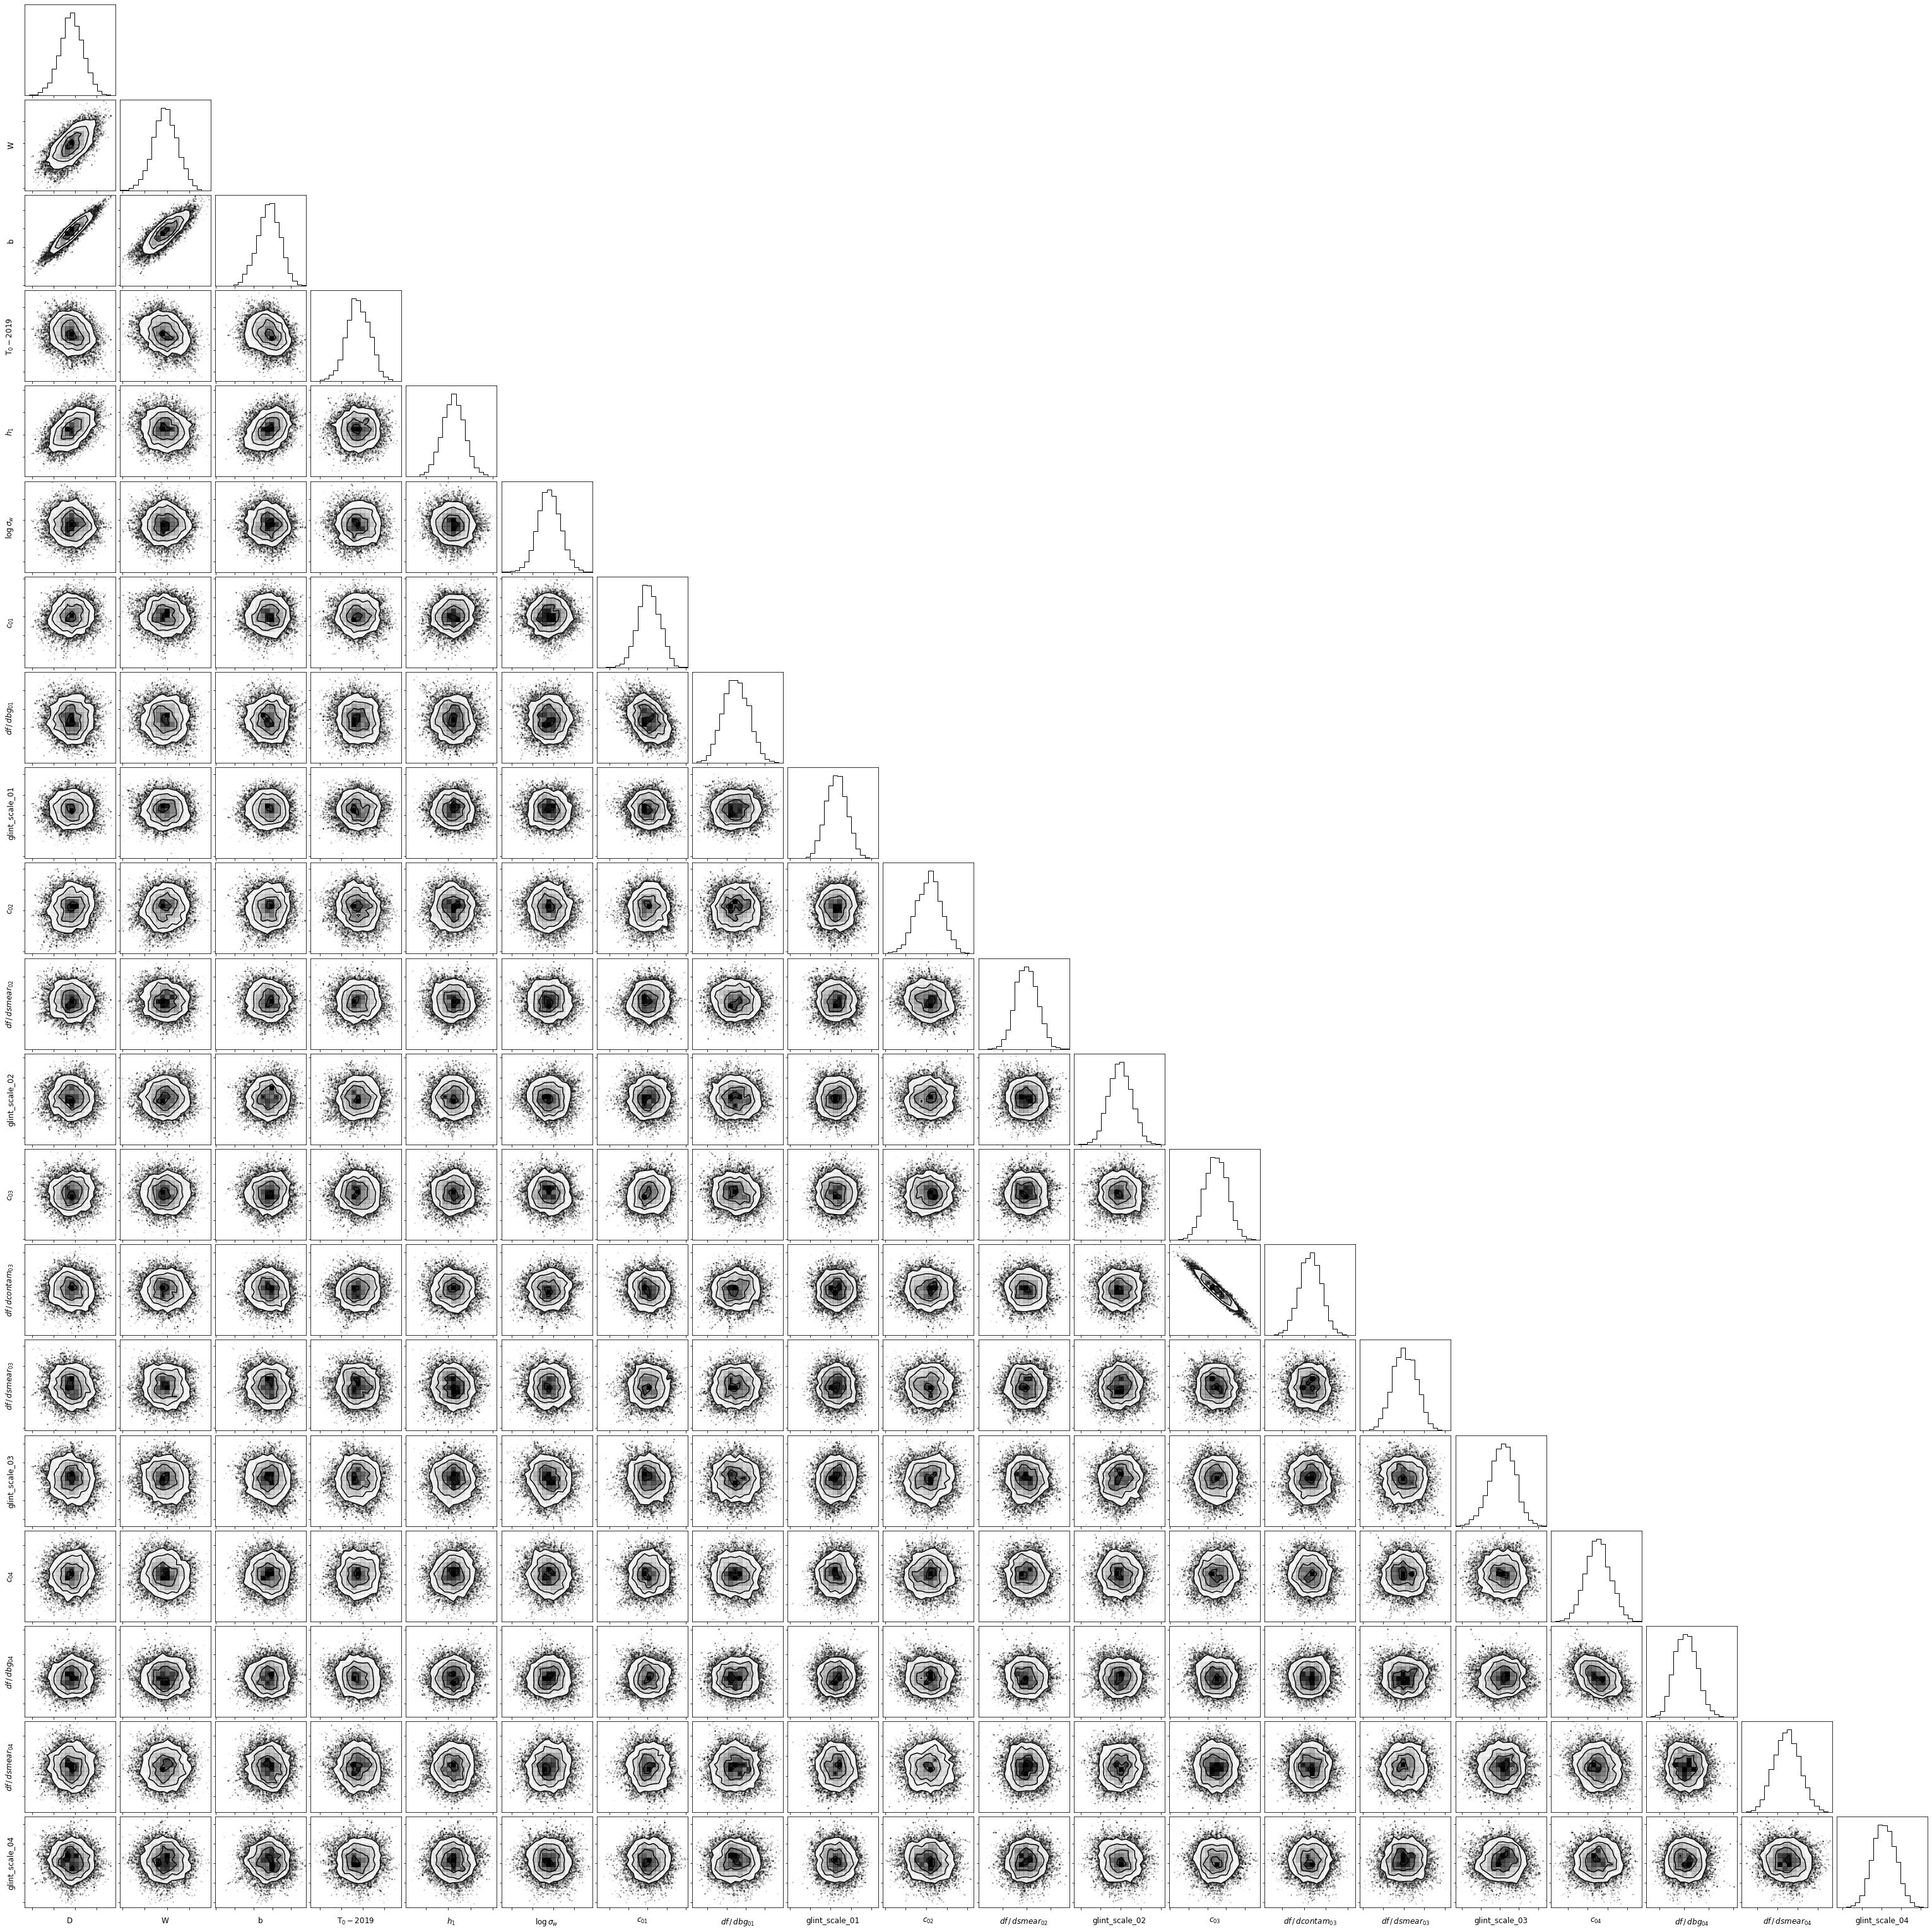

In [11]:
M.corner_plot(plotkeys='all');

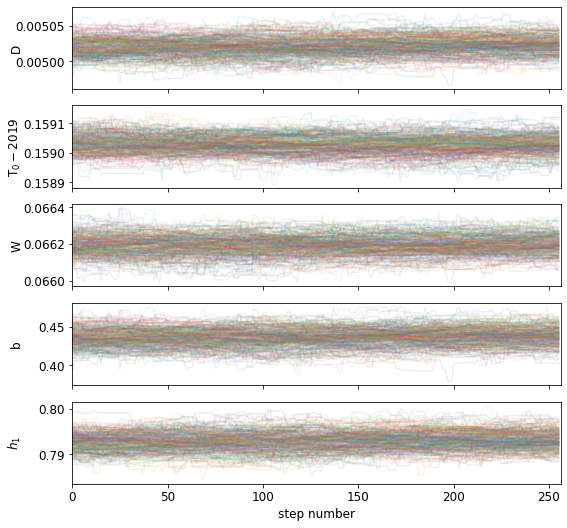

In [12]:
M.trail_plot();

In [13]:
result.params

Parameters([('D',
             <Parameter 'D', value=0.005020767746990553 +/- 1.34e-05, bounds=[0.0009289874260145496:0.01487003506464936]>),
            ('W',
             <Parameter 'W', value=0.06619157237415339 +/- 5.41e-05, bounds=[0.0166939925635284:0.2671038810164544]>),
            ('b',
             <Parameter 'b', value=0.43638545607777685 +/- 0.0121, bounds=[0:1]>),
            ('P', <Parameter 'P', value=2.7240338 (fixed), bounds=[0:inf]>),
            ('T_0',
             <Parameter 'T_0', value=2019.159025865004 +/- 3.24e-05, bounds=[2019.0705024298165:2019.250966445098]>),
            ('f_c', <Parameter 'f_c', value=0.0 (fixed), bounds=[-1:1]>),
            ('f_s', <Parameter 'f_s', value=0.0 (fixed), bounds=[-1:1]>),
            ('h_1',
             <Parameter 'h_1', value=0.792916595864647 +/- 0.00204, bounds=[0:1]>),
            ('h_2', <Parameter 'h_2', value=0.529 (fixed), bounds=[0:1]>),
            ('k',
             <Parameter 'k', value=0.07085737609445154, bounds=[0:1], expr='sqrt(D)'>),
            ('aR',
             <Parameter 'aR', value=4.702678035232704, bounds=[1:inf], expr='sqrt((1+k)**2-b**2)/W/pi'>),
            ('sini',
             <Parameter 'sini', value=0.995685226516263, bounds=[-inf:inf], expr='sqrt(1 - (b/aR)**2)'>),
            ('logrho',
             <Parameter 'logrho', value=-0.7257025509224294, bounds=[-9:6], expr='log10(4.3275e-4*((1+k)**2-b**2)**1.5/W**3/P**2)'>),
            ('e',
             <Parameter 'e', value=0.0, bounds=[0:1], expr='f_c**2 + f_s**2'>),
            ('q_1',
             <Parameter 'q_1', value=0.22184099999999998, bounds=[0:1], expr='(1-h_2)**2'>),
            ('q_2',
             <Parameter 'q_2', value=0.5603324752964904, bounds=[0:1], expr='(h_1-h_2)/(1-h_2)'>),
            ('log_sigma_w',
             <Parameter 'log_sigma_w', value=-9.857821326235166 +/- 0.0437, bounds=[-12:-2]>),
            ('c_01',
             <Parameter 'c_01', value=1.0000504181126124 +/- 5.7e-06, bounds=[0.49714974621829444:2.0005240688373305]>),
            ('dfdbg_01',
             <Parameter 'dfdbg_01', value=0.0001975633363003633 +/- 5.44e-05, bounds=[-inf:inf]>),
            ('glint_scale_01',
             <Parameter 'glint_scale_01', value=1.0705266264540017 +/- 0.128, bounds=[0:2]>),
            ('c_02',
             <Parameter 'c_02', value=1.0000171741028827 +/- 4.99e-06, bounds=[0.4970110427818445:2.000734565507997]>),
            ('dfdsmear_02',
             <Parameter 'dfdsmear_02', value=3.975117775900683e-05 +/- 1.82e-05, bounds=[-inf:inf]>),
            ('glint_scale_02',
             <Parameter 'glint_scale_02', value=0.9927192154138722 +/- 0.116, bounds=[0:2]>),
            ('c_03',
             <Parameter 'c_03', value=1.0000583295449479 +/- 2.36e-05, bounds=[0.4970637542598137:2.0006671250843504]>),
            ('dfdcontam_03',
             <Parameter 'dfdcontam_03', value=-5.69293618022492e-05 +/- 4.01e-05, bounds=[-inf:inf]>),
            ('dfdsmear_03',
             <Parameter 'dfdsmear_03', value=4.0961018431683266e-05 +/- 2.38e-05, bounds=[-inf:inf]>),
            ('glint_scale_03',
             <Parameter 'glint_scale_03', value=1.034666818648304 +/- 0.165, bounds=[0:2]>),
            ('c_04',
             <Parameter 'c_04', value=1.000052083288549 +/- 5.07e-06, bounds=[0.497153050389448:2.000579111813598]>),
            ('dfdbg_04',
             <Parameter 'dfdbg_04', value=0.00015899975309529684 +/- 6.85e-05, bounds=[-inf:inf]>),
            ('dfdsmear_04',
             <Parameter 'dfdsmear_04', value=4.3692018174386056e-05 +/- 1.92e-05, bounds=[-inf:inf]>),
            ('glint_scale_04',
             <Parameter 'glint_scale_04', value=1.0323701887436558 +/- 0.151, bounds=[0:2]>)])